In [469]:
%load_ext autoreload
%autoreload 2
%pylab inline

import os.path as op
import findspark
import os
findspark.init()

import pyspark
sc = pyspark.SparkContext()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-1-04367661b21a>:11 

In [470]:
import shortuuid
shortuuid.uuid()

'UDHuTe5e9ctYwmzrRZBRZm'

## Utility functions

In [471]:
assembly = 'hg19'

In [472]:
data_dir = op.expanduser("~/data")
output_dir = op.join(data_dir, assembly)   # where all of the intermediate output will be stored
base_ucsc_dir = op.join(data_dir, 'ucsc-data/{}'.format(assembly))  # where all of the files downloaded from UCSC will be stored

import shutil

# create a directory to store intermediate output files
def get_outfile(table_name):
    outfile = op.join(output_dir, 'genbank-output/{}'.format(table_name))
    if op.exists(outfile):
        shutil.rmtree(outfile)
    return outfile

## Load the chromosome lengths

In [473]:
#wget http://hgdownload.cse.ucsc.edu/goldenpath/hg19/database/chromInfo.txt.gz
#mv chromInfo.txt.gz ~/data/ucsc-data/hg19/

def get_chrom_lengths(base_dir):
    '''
    Get the cumulative start positions for the chromosomes in an assembly. The chromosomes
    will be sorted alphabetically by their names.
    
    :param base_dir: A directory containing meta data about a genome assembly
    :return: A dictionary of the from { 'chr2': 234323432 }, showing at which position
             chromosomes start.
    '''
    chromLengths = (sc.textFile(op.join(base_dir, 'chromInfo.txt.gz'))
                    .map(lambda x: x.split('\t'))
                    .map(lambda x: {'chrom': x[0], 'length': int(x[1]) })
                    .collect())
    
    cum_chrom_lengths = {}
    curr_cum_lengths = 0
    
    for x in sorted(chromLengths, key=lambda x: -x['length']):
        cum_chrom_lengths[x['chrom']] = curr_cum_lengths
        curr_cum_lengths += x['length']
        
    return cum_chrom_lengths

cum_chrom_lengths = get_chrom_lengths(base_ucsc_dir)

print cum_chrom_lengths['chr1'], cum_chrom_lengths['chr2'], cum_chrom_lengths['chr3']

0 249250621 492449994


## Loading the refgene data

In [474]:
human_gene2pubmed = (sc.textFile(op.join(base_dir, "human/human_gene2pubmed"))
                        .filter(lambda x: x[0] != '#')
                        .map(lambda x: x.split('\t'))
                        .map(lambda x: ((int(x[0]), int(x[1])), int(x[2])))
                     )
print human_gene2pubmed.take(1)

t1 = time.time()
pubmeds_set = set([x[1] for x in human_gene2pubmed.collect()])
t2 = time.time()
print "time taken", t2 - t1

[((9606, 1), 2591067)]
time taken 12.3555929661


In [475]:
from pyspark import SparkContext, SparkConf

# wget http://hgdownload.cse.ucsc.edu/goldenpath/hg19/database/refGene.txt.gz
# mv refGene.txt.gz ~/data/ucsc-data/
def parse_exon_positions(exon_positions_str):
    return map(int, exon_positions_str.strip(",").split(','))

def load_refgene_data(base_dir):
    '''
    Load the UCSC refgene data for a particular assembly.
    
    :param base_dir: The directory which contains the refGene.txt.gz file.
    '''
    refGene = (sc.textFile(op.join(base_dir, 'refGene.txt.gz'))
               .map(lambda x: x.split('\t'))
               .map(lambda x: {'name': x[1],
                               'chrom': x[2],
                               'strand': x[3],
                               'txStart': x[4],
                               'txEnd': x[5],
                               'cdsStart': x[6],
                               'cdsEnd': x[7],
                               'exonCount': x[8],
                               'exonStarts': x[9].strip(','),
                               'exonEnds': x[10].strip(','),
                               'chromOffset': cum_chrom_lengths[x[2]],
                               'genomeTxStart': cum_chrom_lengths[x[2]] + int(x[4]),
                               'genomeTxEnd': cum_chrom_lengths[x[2]] + int(x[5]),
                               'geneName': x[12],
                               'geneLength': int(x[5]) - int(x[4]),
                               })
               .filter(lambda x: x['chrom'].find('_') == -1)
               .filter(lambda x: x['name'] )
            )
    
    return refGene

refGene = load_refgene_data(base_ucsc_dir)
### add the genomic position
refgene_dict = dict([(t['name'], t) for t in refGene.collect()])

In [476]:
print "refgene length:", len(refgene_dict)
refgene_dict.keys()[:10]

refgene length: 57771


[u'NM_002220',
 u'NM_001003806',
 u'NM_001003805',
 u'NM_001003802',
 u'NM_001003803',
 u'NM_001003800',
 u'NM_001003801',
 u'NM_001003809',
 u'NM_001304464',
 u'NM_001304465']

In [477]:
base_dir = op.join(data_dir, 'genbank-data')
taxid_gene_info_human = (sc.textFile(op.join(base_dir, 'human/human_gene_info'))
                   .filter(lambda x: x[0] != '#')
                   .map(lambda x: x.split('\t'))
                   .filter(lambda x: x[0] == "9606")
                   .map(lambda x: ((int(x[0]), int(x[1])),(x[2], x[8], x[9])))
                   )
taxid_gene_info_human.take(1)

[((9606, 1), (u'A1BG', u'alpha-1-B glycoprotein', u'protein-coding'))]

In [478]:
taxid_gene_refseq_id = (sc.textFile(op.join(base_dir, "human/human_gene2refseq"))
                        .filter(lambda x: x[0] != '#')
                        .map(lambda x: x.split('\t'))
                        .filter(lambda x: x[3].split('.')[0] in refgene_dict)
                        .map(lambda x: ((int(x[0]), int(x[1])), (x[3].split('.')[0])))
                        )
taxid_gene_refseq_id.take(1)

[((9606, 1), u'NM_130786')]

In [479]:
import time
t1 = time.time()
taxid_gene_info_refseq = taxid_gene_info_human.join(taxid_gene_refseq_id)

t2 = time.time()
print "time taken", t2 - t1

time taken 9.16409897804


In [480]:
2069907  in pubmeds_set

True

In [481]:
len(pubmeds_set)
human_year_pmid = (sc.textFile(op.join(base_dir, 'recent_pmid_year.ssv'))
                  .map(lambda x: x.split())
                  .map(lambda x: (int(x[0]), int(x[1])))
                  .filter(lambda x: x[1] in pubmeds_set))
human_year_pmid_collected = human_year_pmid.collect()

In [482]:
pmid_year = dict([(x[1], x[0]) for x in human_year_pmid_collected])

In [483]:
taxid_gene_info_pubmed = (taxid_gene_info_human.join(human_gene2pubmed)
                    .filter(lambda x: x[1][1] in pmid_year)
                                 .map(lambda x: ((x[0][0], x[0][1], x[1][1]), x[1])))
taxid_gene_info_pubmed.take(1)        

[((9606, 100847044, 16381832),
  ((u'MIR5087', u'microRNA 5087', u'ncRNA'), 16381832))]

In [484]:
gene_counts = sorted(taxid_gene_info_pubmed.map(lambda x: ((x[0][0], x[0][1]), (x[1][0], 1)))
.reduceByKey(lambda x1, x2: (x1[0], x1[1] + x2[1]))
.collect(), key=lambda x: -x[1][1])

gene_counts[:3]

[((9606, 7157), ((u'TP53', u'tumor protein p53', u'protein-coding'), 6620)),
 ((9606, 7124), ((u'TNF', u'tumor necrosis factor', u'protein-coding'), 4431)),
 ((9606, 7316), ((u'UBC', u'ubiquitin C', u'protein-coding'), 3444))]

In [485]:
taxid_gene_info_year = (taxid_gene_info_pubmed.map(lambda x: ((x[0][0], x[0][1], pmid_year[x[1][1]]), x[1]))
                        .map(lambda x: ((x[0][0], x[0][1], pmid_year[x[1][1]]), (x[1][0], 1)))
                                 .reduceByKey(lambda x1, x2: (x1[0], x1[1] + x2[1])))
print taxid_gene_info_year.take(1)
print taxid_gene_info_year.count()
print taxid_gene_info_year.filter(lambda x: x[1][0][2] == 'rRNA').take(1)

[((9606, 1939, 2010), ((u'EIF2D', u'eukaryotic translation initiation factor 2D', u'protein-coding'), 3))]
254200
[((9606, 100008588, 1987), ((u'RNA18S5', u'RNA, 18S ribosomal 5', u'rRNA'), 1))]


In [486]:
genes_per_year = dict(taxid_gene_info_pubmed.map(lambda x: ((pmid_year[x[1][1]], x[0][1]), 1))
 .reduceByKey(lambda x1,x2: x1+x2)
 .map(lambda x: (x[0][0], 1))
 .reduceByKey(lambda x1,x2: x1+x2)
 .collect())

citations_per_year = dict((taxid_gene_info_pubmed.map(lambda x: (pmid_year[x[1][1]], 1))
                      .reduceByKey(lambda x1,x2: x1+x2)
                      .collect()))

In [487]:
citation_genes = sorted(taxid_gene_info_pubmed.map(lambda x: (x[1][1], 1))
 .reduceByKey(lambda x1, x2: x1 + x2)
 .collect(), key=lambda x: -x[1])

In [488]:
citation_genes[:10]

[(12477932, 19792),
 (15489334, 11518),
 (14702039, 10080),
 (16344560, 5986),
 (21139048, 5465),
 (21906983, 5035),
 (21890473, 4623),
 (24816145, 3522),
 (18029348, 3323),
 (21963094, 3173)]

In [489]:
gene_types_citations = (taxid_gene_info_pubmed.map(lambda x: (x[1][0][2], 1))
 .reduceByKey(lambda x1,x2: x1+x2)
 .collect()
)
gene_types_citations

[(u'pseudo', 10278),
 (u'unknown', 2309),
 (u'snoRNA', 1274),
 (u'snRNA', 194),
 (u'tRNA', 1017),
 (u'protein-coding', 956924),
 (u'rRNA', 106),
 (u'ncRNA', 18745),
 (u'other', 2387)]

In [490]:
gene_types_counts = (taxid_gene_info_pubmed.map(lambda x: ((x[1][0][2], x[0][1]),1))
 .reduceByKey(lambda x1,x2: x1+x2)
 .map(lambda x: (x[0][0], 1))
 .reduceByKey(lambda x1,x2: x1+x2)
 .collect())

for gtc in gene_types_counts:
    print gtc[0], gtc[1]


pseudo 5715
tRNA 512
snoRNA 389
snRNA 68
unknown 1518
protein-coding 19469
rRNA 6
ncRNA 5029
other 747


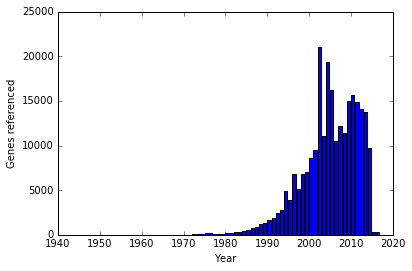

In [491]:
years = genes_per_year.keys()
fig, ax = plt.subplots()
ax.bar(years, [genes_per_year[y] for y in years])
plt.xlabel("Year")
plt.ylabel("Genes referenced")
plt.savefig("genes_per_year.png")

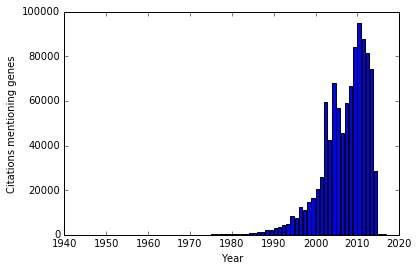

In [492]:
years = citations_per_year.keys()
fig, ax = plt.subplots()
ax.bar(years, [citations_per_year[y] for y in years])
plt.xlabel("Year")
plt.ylabel("Citations mentioning genes")
plt.savefig("citations_per_year.png")

In [493]:
string_values = (taxid_gene_info_year.map(lambda x: "\t".join(map(str, 
                 [x[0][0], x[0][1], x[0][2], x[1][0][0], x[1][0][1], x[1][0][2], x[1][1]
                 ])))
                 .collect())
with open('gene_info_by_year.tsv', 'w') as f:
    for sv in string_values:
        f.write(sv + "\n")

In [494]:
joined = (taxid_gene_info_refseq.join(human_gene2pubmed)
                                 .filter(lambda x: x[1][1] in pmid_year)
                                 .map(lambda x: ((x[0][0], x[0][1], x[1][1]), x[1])))
print joined.take(1)
print joined.count()

[((9606, 8604, 9722566), (((u'SLC25A12', u'solute carrier family 25 (aspartate/glutamate carrier), member 12', u'protein-coding'), u'NM_003705'), 9722566))]
2458367


In [495]:
rjoined = (joined.reduceByKey(lambda x1, x2: x1)
                 .map(lambda x: ((x[0][0], x[0][1]), x[1]))
           )
rjoined.take(5)

[((9606, 2475),
  (((u'MTOR',
     u'mechanistic target of rapamycin (serine/threonine kinase)',
     u'protein-coding'),
    u'NM_004958'),
   20038818)),
 ((9606, 414332),
  (((u'LCN10', u'lipocalin 10', u'protein-coding'), u'NM_001001712'),
   14702039)),
 ((9606, 3356),
  (((u'HTR2A',
     u'5-hydroxytryptamine (serotonin) receptor 2A, G protein-coupled',
     u'protein-coding'),
    u'NM_000621'),
   24257701)),
 ((9606, 161835),
  (((u'FSIP1', u'fibrous sheath interacting protein 1', u'protein-coding'),
    u'NM_152597'),
   20379614)),
 ((9606, 4318),
  (((u'MMP9',
     u'matrix metallopeptidase 9 (gelatinase B, 92kDa gelatinase, 92kDa type IV collagenase)',
     u'protein-coding'),
    u'NM_004994'),
   19383343))]

In [497]:
taxid_gene_info_refseq_pubmed = (rjoined
                                 .map(lambda x: ((x[0][0], x[0][1], pmid_year[x[1][1]]), (x[1][0], 1)))
                                 .reduceByKey(lambda x1, x2: (x1[0], x1[1] + x2[1]))
                                 )

t1 = time.time()
print taxid_gene_info_refseq_pubmed.take(1)
#taxid_gene_info_collected1 = taxid_gene_info_refseq_pubmed.collect()
t2 = time.time()
print "time:", t2 - t1

[((9606, 6597, 1996), (((u'SMARCA4', u'SWI/SNF related, matrix associated, actin dependent regulator of chromatin, subfamily a, member 4', u'protein-coding'), u'NM_001128844'), 5))]
time: 10.7281460762


In [ ]:
with open('by_year.tsv', 'w') as f:
    for x in taxid_gene_info_collected1:
        #print x
        refseq_id = x[1][0][1].split('.')[0]
        if refseq_id not in refgene_dict:
            continue
        refseq_data = refgene_dict[refseq_id]
        #print refseq_data
        out_str = "\t".join(map(str, [x[0][0], x[0][1], x[0][2], refseq_id, refseq_data['chrom'],
                                  refseq_data['txStart'], refseq_data['txEnd'],
                                  x[1][0][0][0], x[1][0][0][1], x[1][0][0][2], x[1][1]]))
        f.write(out_str + "\n")
        

In [501]:
taxid_gene_info_all = (taxid_gene_info_refseq_pubmed.map(lambda x: ((x[0][0], x[0][1]), x[1]))
                       .reduceByKey(lambda x1,x2: (x1[0], x1[1] + x2[1]))
                       )

print taxid_gene_info_all.take(1)
taxid_gene_info_all_collected = taxid_gene_info_all.collect()

[((9606, 56900), (((u'TMEM167B', u'transmembrane protein 167B', u'protein-coding'), u'NM_020141'), 6))]


In [503]:
with open('all_gene_counts.tsv', 'w') as f:
    for x in taxid_gene_info_all_collected:
        #print x
        refseq_id = x[1][0][1].split('.')[0]
        if refseq_id not in refgene_dict:
            continue
        refseq_data = refgene_dict[refseq_id]
        #print refseq_data
        out_str = "\t".join(map(str, [x[0][0], x[0][1], refseq_id, refseq_data['chrom'],
                                  refseq_data['txStart'], refseq_data['txEnd'],
                                  x[1][0][0][0], x[1][0][0][1], x[1][0][0][2], x[1][1]]))
        f.write(out_str + "\n")
        

In [504]:
# head all_gene_counts.tsv > short_all_gene_counts.tsv

ERROR: Line magic function `%shell` not found.


In [226]:
import streamgraph

In [242]:
import pandas as pd
sorted_non_protein = pd.read_csv('sorted_non_protein_gene_info_by_year.tsv', names=['taxid', 'geneid', 'year', 'symbol', 'name', 'type', 'citations'],
                                delimiter='\t')
sorted_non_protein.head()
min_year = min(sorted_non_protein['year'])
max_year = max(sorted_non_protein['year'])
types = dict([(x,i) for i,x in enumerate(set(sorted_non_protein['type']))])

print min_year, max_year
print "types:", types
print sorted_non_protein.head()

1950 2016
types: {'rRNA': 0, 'snRNA': 1, 'unknown': 2, 'pseudo': 3, 'other': 4, 'tRNA': 5, 'snoRNA': 6, 'ncRNA': 7}
   taxid  geneid  year symbol  \
0   9606    4981  1950   OPEM   
1   9606  727714  1958  SCAX2   
2   9606    4434  1960    MSD   
3   9606  353173  1965    ZLS   
4   9606    7063  1965    THM   

                                                name     type  citations  
0             ophthalmoplegia, external, with myopia  unknown          1  
1                 spinocerebellar ataxia, X-linked 2  unknown          1  
2  microcephaly with spastic diplegia (Paine synd...  unknown          1  
3                          Zimmerman-Laband Syndrome  unknown          1  
4                                            thymoma  unknown          1  


In [238]:
import collections as col
year_type_counts = col.defaultdict(lambda: col.defaultdict(int))

for ix, row in sorted_non_protein.iterrows():
    year_type_counts[row['year']][row['type']] += row['citations']

In [400]:
layers = []

for type in types:
    type_counts = []
    for year in range(min_year, max_year+1):
    
        type_counts += [year_type_counts[year][type]]
    layers += [type_counts]

print layers

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 4, 7, 4, 11, 8, 10, 5, 14, 17, 4, 5, 3, 4, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 5, 10, 1, 8, 8, 2, 1, 3, 0, 2, 2, 5, 0, 1, 2, 3, 2, 3, 0, 0, 2, 9, 13, 7, 5, 0, 40, 3, 2, 8, 10, 24, 6, 6, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 3, 1, 0, 1, 2, 1, 2, 1, 3, 4, 3, 2, 5, 8, 0, 6, 10, 4, 10, 15, 7, 14, 12, 29, 12, 34, 35, 64, 56, 99, 92, 143, 199, 287, 175, 316, 72, 66, 76, 93, 74, 82, 71, 61, 39, 12, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 1, 2, 19, 18, 14, 53, 49, 54, 50, 80, 78, 100, 88, 149, 163, 221, 127, 185, 186, 595, 250, 263, 384, 959, 740, 724, 415, 213, 236, 341, 2165, 451, 340, 244, 217, 97, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 8, 4, 3, 3, 7, 2, 80, 1, 2

streams.shape (50, 100)


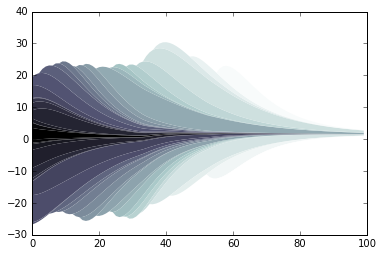

In [401]:
import matplotlib.pyplot as pl
import numpy as np

def symmetric(sorted_streams, stream_bounds):
    """Symmetric baseline"""
    lb, ub = np.min(stream_bounds[:,0,:],axis=0), np.max(stream_bounds[:,1,:],axis=0)
    return .5*(lb+ub)
def pos_only(sorted_streams, stream_bounds):
    """Lumps will only be positive"""
    lb, ub = np.min(stream_bounds[:,0,:],axis=0), np.max(stream_bounds[:,1,:],axis=0)
    return lb
def zero(sorted_streams, stream_bounds):
    """Zero baseline"""
    return np.zeros(stream_bounds.shape[2])
def min_weighted_wiggles(sorted_streams, stream_bounds):
    """Baseline recommended by Byron and Wattenberg"""
    lb, ub = np.min(stream_bounds[:,0,:],axis=0), np.max(stream_bounds[:,1,:],axis=0)
    weight = ub-lb
    
    sorted_streams = np.abs(sorted_streams)
    for i in xrange(len(sorted_streams)):
        sorted_streams[i,:] *= (-1)**i
    cusum_f = np.vstack((np.zeros(sorted_streams.shape[1]),
                        np.cumsum(sorted_streams[:-1,:], axis=0)))
    f_prime = np.diff(sorted_streams, axis=1)
    cusum_f_prime = np.diff(cusum_f, axis=1)
    g_prime = np.hstack(([0],-np.sum((f_prime*.5  + cusum_f_prime)*sorted_streams[:,1:],axis=0) / weight[1:]))
    g_prime[np.where(weight==0)] = 0
    g = np.cumsum(g_prime)
    
    return g
    

def stacked_graph(streams, cmap=pl.cm.bone, color_seq='linear', 
                  baseline_fn=min_weighted_wiggles, ax=None, 
                  labels=None, xvalues=None):
    """
    Produces stacked graphs using matplotlib.
    
    Reference: 'Stacked graphs- geometry & aesthetics' by Byron and Wattenberg
    http://www.leebyron.com/else/streamgraph/download.php?file=stackedgraphs_byron_wattenberg.pdf
    
    Parameters:
      - streams: A list of time-series of positive values. Each element must be of the same length.
      - cmap: A matplotlib color map. Defaults to 'bone'.
      - colo_seq: 'linear' or 'random'.
      - baseline_fn: Current options are symmetric, pos_only, zero and min_weighted_wiggles.
    """
    # Sort by onset times
    onset_times = [np.where(np.abs(stream)>0)[0][0] for stream in streams]
    order = np.argsort(onset_times)
    streams = np.asarray(streams)
    if labels is not None:
        labels = [labels[i] for i in order]
    sorted_streams = streams[order]
    
    if xvalues is None:
        t = np.arange(streams.shape[1])
    else:
        t = xvalues
    
    # Establish bounds
    stream_bounds = [np.vstack((np.zeros(streams.shape[1]), sorted_streams[0])),
                    np.vstack((-sorted_streams[1], (np.zeros(streams.shape[1]))))]
    side = -1
    for stream in sorted_streams[2:]:
        side *= -1
        if side==1:
            stream_bounds.append(np.vstack((stream_bounds[-2][1], stream_bounds[-2][1]+stream)))
        else:
            stream_bounds.append(np.vstack((stream_bounds[-2][0]-stream, stream_bounds[-2][0])))
            
    stream_bounds = np.array(stream_bounds)
    
    # Compute baseline
    baseline = baseline_fn(sorted_streams, stream_bounds)
    
    print "streams.shape", streams.shape
    if labels is None:
        labels = ['' for i in range(streams.shape[0])]
    
    # Choose colors
    t_poly = np.hstack((t,t[::-1]))
    if color_seq=='linear':
        colors = np.linspace(0,1,streams.shape[0])
    elif color_seq=='random':
        colors = np.random.random(size=streams.shape[1])
    else:
        raise ValueError, 'Color sequence %s unrecognized'%color_seq
    
    # Plot    
    #pl.axis('off') 
    if ax is None:
        fig, ax = plt.subplots()
    for i in xrange(len(stream_bounds)):
        bound = stream_bounds[i]
        color = cmap(colors[i])
        ax.fill(t_poly, np.hstack((bound[0]-baseline,(bound[1]-baseline)[::-1])), 
                facecolor=color, linewidth=0.,edgecolor='none',label=labels[i])
        
        
# Demo
if __name__ == '__main__':
    pl.clf()
    N_dsets = 50
    T = 100
    amp = 1
    fade = .15
    dsets = []
    for i in xrange(N_dsets):
        this_dset = np.zeros(T)
        t_onset = np.random.randint(.9*T)-T/3
        if t_onset >= 0:   
            remaining_t = np.arange(T-t_onset)     
        else:
            remaining_t = np.arange(T)-t_onset
        this_dset[max(t_onset,0):]=np.exp(-.15*np.random.gamma(10,.1)*remaining_t)\
                            * remaining_t * np.random.gamma(6,.2) # * np.cos(-fade*remaining_t*np.random.gamma(10,.1))**2
        dsets.append(this_dset)
    
    stacked_graph(dsets, baseline_fn = min_weighted_wiggles, color_seq='linear')


streams.shape (8, 67)
labels: [u'', u'', u'', u'', u'', u'', u'', u'']
len a: 67
2016


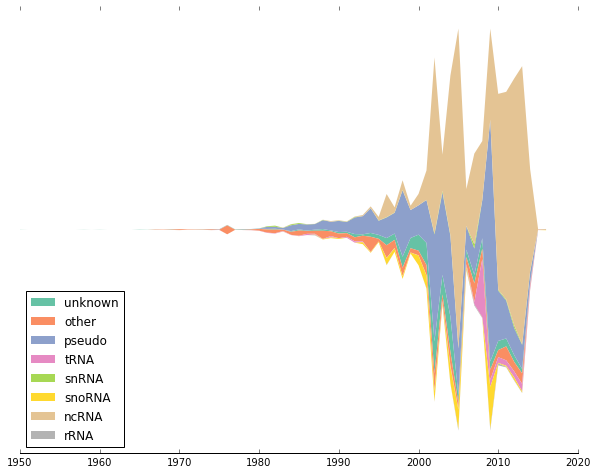

In [402]:
fig,ax=plt.subplots(figsize=(10,8))
stacked_graph(np.array(layers), baseline_fn = symmetric,
              cmap=pl.cm.Set2 , color_seq='linear', ax=ax, labels=[t for t in types],
             xvalues=range(min_year, max_year+1))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=3)

labels = [item.get_text() for item in ax.get_xticklabels()]
print "labels:", labels
#a =  [x for x in range(min_year, max_year, (max_year - min_year) / len(labels))]
print "len a:", len(layers[0])
ax.get_yaxis().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

print max_year


In [428]:
import pandas as pd
sorted_gene_info = pd.read_csv('sorted_gene_info_by_year.tsv', names=['taxid', 'geneid', 'year', 'symbol', 'name', 'type', 'citations'],
                                delimiter='\t')
sorted_non_protein.head()
min_year = min(sorted_non_protein['year']) 
#min_year = 2000
max_year = max(sorted_non_protein['year'])

print min_year, max_year
print sorted_gene_info.head()

1950 2016
   taxid  geneid  year symbol  \
0   9606    2787  1946   GNG5   
1   9606    4981  1950   OPEM   
2   9606    7369  1952   UMOD   
3   9606   10249  1954  GLYAT   
4   9606    1393  1954  CRHBP   

                                                name            type  \
0  guanine nucleotide binding protein (G protein)...  protein-coding   
1             ophthalmoplegia, external, with myopia         unknown   
2                                         uromodulin  protein-coding   
3                          glycine-N-acyltransferase  protein-coding   
4    corticotropin releasing hormone binding protein  protein-coding   

   citations  
0          1  
1          1  
2          1  
3          1  
4          1  


/Users/pkerp/.virtualenvs/stuff/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/pkerp/.virtualenvs/stuff/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [463]:
all_genes = set()
all_year_genes = col.defaultdict(lambda: col.defaultdict(int))
all_decade_genes = col.defaultdict(lambda: col.defaultdict(int))
all_genes_citations = col.defaultdict(int)

for year in range(min_year, max_year+1):
    for ix, row in  (sorted_gene_info[sorted_gene_info['year'] == year]
                    .sort('citations', ascending=[False]).iterrows()):
        
        all_year_genes[year][row['symbol']] = row['citations']
        all_genes.add(row['symbol'])
        all_decade_genes[year / 10][row['symbol']] += row['citations']
        all_genes_citations[row['symbol']] += row['citations']
        
        
with open('all_year_genes.tsv', 'w') as f:
    f.write("gene\t{}\n".format("\t".join(map(str, range(min_year, max_year+1)))))

    for gene in all_genes:
        str_counts = []    
        for year in range(min_year, max_year+1):
            if gene in all_year_genes[year]:
                str_counts += [str(all_year_genes[year][gene])]
            else:
                str_counts += ['']
            #print year / 10, top_half_decades[year / 10]
        out_str = "{gene}\t{counts}".format(gene=gene, counts="\t".join(str_counts))
        f.write(out_str + "\n")
        #print out_str

/Users/pkerp/.virtualenvs/stuff/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## Genes by decade

In [465]:
with open('all_decade_genes.tsv', 'w') as f:
    f.write("gene\t{}\n".format("\t".join(map(str, range(min_year, max_year+1, 10)))))
    for gene in all_genes:
        str_counts = []    
        for year in range(min_year, max_year+1, 10):
            if gene in all_decade_genes[year / 10]:
                str_counts += [str(all_decade_genes[year / 10][gene])]
            else:
                str_counts += ['']
            #print year / 10, top_half_decades[year / 10]
        out_str = "{gene}\t{counts}".format(gene=gene, counts="\t".join(str_counts))
        f.write(out_str + "\n")
        print out_str

LOC100506869							1
LOC102724604						1	
MTVR2						1	
LOC100506860						1	
UBE2Q2						9	7
CHMP1B						25	17
LOC102723463							1
LOC102723466						1	
EPWW6493						1	
LOC651959						1	
CPHL1P						2	1
LOC441204						3	
TCOF1					13	35	31
NSRP1						13	10
OPA6						1	
SPPL3					1	13	4
OPA4					1	1	
OPA5						2	
OPA2					1		
OPA3		1			2	15	11
OPA1					3	93	71
RNF219-AS1						1	2
ITGA8					5	15	12
ITGA9					7	21	21
ITGA1				2	26	56	28
ITGA2				3	38	228	84
ITGA3				3	28	112	43
ITGA4				3	26	117	73
ITGA5				7	41	139	102
ITGA6				3	27	105	69
ITGA7					15	23	11
TRHR					12	14	4
CA15P1						1	
CA15P2						1	
CA15P3						1	
UFSP1						7	4
UFSP2						8	3
LOC101928372						1	
TEX28P2					1	2	
TEX28P1					1	1	
FAM212B						6	2
FAM212A						3	3
CHST9					2	6	5
CHST8					2	8	5
CHST1					8	13	4
CHST3					4	13	8
CHST2					6	15	2
CHST5					3	13	1
CHST4					3	18	1
CHST7					2	10	1
CHST6					3	34	4
ITGAX				4	14	38	27
RPS4XP1						1	
RPS4XP6						1	
RPS4XP7						1	
RPS4XP4						1	
BCL2A1					17	42	23


In [ ]:
layers = []
all_genes = set()
top_n = 20

# tabulate the top ten genes for each year
top_tens = col.defaultdict(lambda: col.defaultdict(int))
top_half_decades = col.defaultdict(lambda: col.defaultdict(int))
        
for year in range(min_year, max_year+1):
    for ix, row in  (sorted_gene_info[sorted_gene_info['year'] == year]
                    .sort('citations', ascending=[False]).head(top_n).iterrows()):
        top_tens[year][row['symbol']] = row['citations']
        top_half_decades[year / 10][row['symbol']] += row['citations']
        all_genes.add(row['symbol'])
    

In [456]:
stacks = [[0 for i in range(min_year, max_year+1)] for i in range(len(all_genes))]
stack_idxs = dict([(x,i) for (i,x) in enumerate(all_genes)])

print "len:", len(stacks)

for i,year in enumerate(range(min_year, max_year+1)):
    for gene in top_tens[year]:
        #print stack_idxs[gene], stacks[stack_idxs[gene]]
        stacks[stack_idxs[gene]][i] = top_tens[year][gene]
        all_genes.add(gene)


with open('top_ns_year.tsv', 'w') as f:
    f.write("gene\t{}\n".format("\t".join(map(str, range(min_year, max_year+1, 10)))))
    for gene in all_genes:
        str_counts = []    
        for year in range(min_year, max_year+1, 10):
            if gene in top_half_decades[year / 10]:
                str_counts += [str(top_half_decades[year / 10][gene])]
            else:
                str_counts += ['']
            #print year / 10, top_half_decades[year / 10]
        out_str = "{gene}\t{counts}".format(gene=gene, counts="\t".join(str_counts))
        f.write(out_str + "\n")
        print out_str


len: 400
PCSK1			1				
IGHG1			4				
IGHG2		1	2	4			
BMP2							1
SBF2							2
L1CAM							2
IGKC		2	2				
AGT		1				54	
ASS1			2				
ADIPOQ						193	179
TAT		1					
SLC6A4						572	206
PTGER1			1				
TAZ			1				
SPTLC1		1					
IFNA13				3			
LHB			3				
IFNG				4			
APRT			2				
GC				5			
OPA3		1					
GATA1							2
COL7A1		1					
ORM2			1				
PTEN							57
RMRP							2
CDKN1A					24		
COL3A1				6			
APOA1				15			
APOA2			2	6			
IGLV7-46			2				
PLG		2	8	8			
APOE			2	11		2310	1025
APOB				31			
IGLV7-43			2				
TTR	1	1	3	14	30		
PEPC			1				
C4A		1		8			
C4B				3			
COL1A2				9	22		
VEGFA						1703	1365
COL4A1				10			
GARS							2
MB		1	2				
SPG20		1					
CBL		1			81		
INS	1	1	6	4			
CBS			2				
ADFN		1					
IGLV4-69			2				
VWF				13	11		
ACP1			1				
ACP2			2				
SMS		1					
RET					14		2
PRKCSH			1				
SLC4A1			2				
COL2A1		1		11	7		
MKKS							2
GDAP1							3
RBM10		1	1				
ART4		1					
LDLR				16			
TRPV4							2
IL2RA				5			
F2		1	2	11		59	
ACPP			1				
F5						261	
F8				

streams.shape (383, 67)
labels: [u'', u'', u'', u'', u'', u'', u'', u'']


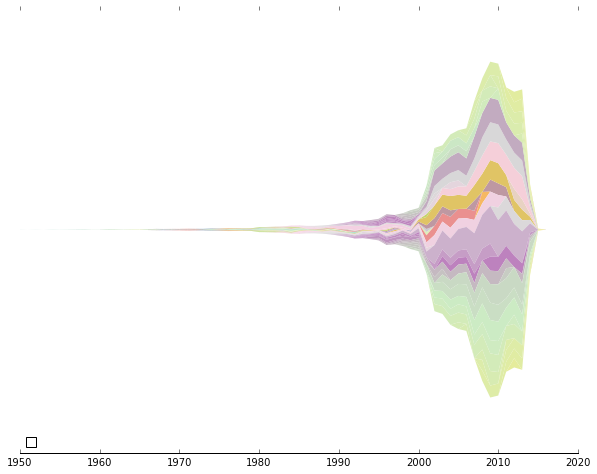

In [431]:
fig,ax=plt.subplots(figsize=(10,8))
stacked_graph(np.array(stacks), baseline_fn = symmetric,
              cmap=pl.cm.Set3 , color_seq='linear', ax=ax, labels=None,
             xvalues=range(min_year, max_year+1))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=3)

labels = [item.get_text() for item in ax.get_xticklabels()]
print "labels:", labels
#a =  [x for x in range(min_year, max_year, (max_year - min_year) / len(labels))]
ax.get_yaxis().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

## Count the references

For this exercise, the result should be a tsv with the following columns:

```
<taxId> <geneId> <refSeqID> <citation count>
```

In [7]:
def count_per_year(genbank_dir):
    '''
    gene2pubmed = (sc.textFile(op.join(genbank_dir, "gene2pubmed"))
                     .filter(lambda x: x[0] != '#')
                     .map(lambda x: x.split('\t'))
                     .map(lambda p: {'taxid': int(p[0]), 'geneid': int(p[1]), 'pmid': int(p[2]), 'count': 1})
                     .map(lambda x: ((x['taxid'], x['geneid']), {'count': x['count']}))
                     )
    '''
    pubmed_gene = (sc.textFile(op.join(genbank_dir, "gene2pubmed"))
                   .filter(lambda x: x[0] != '#')
                   .map(lambda x: x.split('\t'))
                   .map(lambda x: (int(x[1]), int(x[0]))
                  ))
    
    pmid_year = (sc.textFile(op.join(genbank_dir, 'pmid_year.ssv'))
                 .map(lambda x: x.split())
                 .map(lambda x: (int(x[1]), int(x[0].split('-')[0])))
                 )
    print pmid_year.take(1)
    print pubmed_gene.take(1)
    
    pmid_year_gene = pubmed_gene.join(pmid_year)
    return pmid_year_gene
    
pmid_year_gene = count_per_year(op.join(data_dir, 'genbank-data/'))


[(25259337, 1900)]
[(1246500, 9)]


In [7]:
def load_gene_counts(genbank_dir):
    gene2pubmed = (sc.textFile(op.join(genbank_dir, "gene2pubmed"))
                     .filter(lambda x: x[0] != '#')
                     .map(lambda x: x.split('\t'))
                     .map(lambda p: {'taxid': int(p[0]), 'geneid': int(p[1]), 'pmid': int(p[2]), 'count': 1})
                     .map(lambda x: ((x['taxid'], x['geneid']), {'count': x['count']}))
                     )
    
    def reduce_count(r1, r2):
        '''
        A reduce function that simply counts the number of elements in the table.
        
        @param r1: A Row
        @param r2: A Row
        @return: A new Row, equal to the first Row with a summed count.
        '''
        #print >>sys.stderr, "r1:", r1
        r1['count'] += r2['count']
        return r1

    print gene2pubmed.take(1)
    reduced_gene2pubmed = gene2pubmed.reduceByKey(reduce_count)
    
    outfile = get_outfile('taxid-geneid-count')

    (reduced_gene2pubmed
        .map(lambda x: "{}\t{}\t{}".format(x[0][0], x[0][1], x[1]['count']))
        .saveAsTextFile(outfile)
        )
    
    return reduced_gene2pubmed


taxid_geneid_count = load_gene_counts(op.join(data_dir, 'genbank-data/'))
print taxid_geneid_count.take(1)

[((9, 1246500), {'count': 1})]
[((6279, 6095747), {'count': 1})]


## Load the gene2refseq annotations

In [8]:
def take_one(r1, r2):
    return r1

def load_refseq2gene(genbank_base_dir):
    '''
    Get the mapping from refseq IDs to gene IDs
    
    :param genbank_base_dir: The directory that contains all of the genbank files.
    :return: A set of tuples of the form (refseq_id, (taxid, geneid))
    '''
    gene2refseq = (sc.textFile(op.join(genbank_base_dir, 'gene2refseq'))
                   .filter(lambda x: x[0] != '#')
                   .map(lambda x: x.split('\t'))
                   .map(lambda p: {'taxid': int(p[0]), 'geneid': int(p[1]), 'refseqid': p[3] })
                   .map(lambda x: (x['refseqid'].split('.')[0], (x['taxid'], x['geneid'])))
                   )
    
    def reduce_by_refseq_id(r1, r2):
        # because we're just looking for a mapping from geneId to refseqId, we just need to throw
        # away single entries with identical refseq ids
        return r1
    
    print gene2refseq.take(10)
    refseq2gene = gene2refseq.reduceByKey(take_one)
    print refseq2gene.take(1)
    
    outfile = get_outfile('refseqid-taxid-geneid')

    (refseq2gene.map(lambda x: "{}\t{}\t{}".format(x[0], x[1][0], x[1][1]))
         .saveAsTextFile(outfile)
    )
    return refseq2gene

refseqid_taxid_geneid = load_refseq2gene(op.join(data_dir, 'genbank-data'))

[(u'-', (9, 1246500)), (u'-', (9, 1246501)), (u'-', (9, 1246502)), (u'-', (9, 1246503)), (u'-', (9, 1246504)), (u'-', (9, 1246505)), (u'-', (9, 1246509)), (u'-', (9, 1246510)), (u'-', (9, 3722426)), (u'-', (9, 8655732))]
[(u'XM_009054708', (225164, 20243866))]


## Join the reference counts and refseq to geneid translations

In [9]:
print refseqid_taxid_geneid.take(1)

def take_one(r1, r2):
    return r1

def take_max(r1, r2):
    if r1 > r2:
        return r1
    else:
        return r2

[(u'XM_009054708', (225164, 20243866))]


In [10]:
def join_counts_and_ids(refseqid_taxid_geneid, taxid_geneid_count):
    taxid_geneid_refseq = refseqid_taxid_geneid.map(lambda x: (x[1], x[0]))
    print "count1:", taxid_geneid_refseq.count()
    taxid_geneid_refseq = taxid_geneid_refseq.reduceByKey(take_one)
    print "count2:", taxid_geneid_refseq.count()
    
    
    '''    
    taxid_geneid_refseq = (sc.textFile(op.join(output_dir, 'genbank-output/refseqid-taxid-geneid'))
                   .map(lambda x: x.split())
                   .map(lambda x: ((int(x[1]), int(x[2])), x[0]))
                        )
    '''
    print taxid_geneid_refseq.take(1)
    
    '''
    (sc.textFile(op.join(output_dir, 'genbank-output/taxid-geneid-count'))
                          .map(lambda x: x.split())
                          .map(lambda x: ((int(x[0]), int(x[1])), int(x[2])))
                          )
    '''
    print "taxid_geneid_count", taxid_geneid_count.take(1)
    print "1. taxid_geneid_count.count():", taxid_geneid_count.count()
    taxid_geneid_count = taxid_geneid_count.reduceByKey(take_max)
    print "2. taxid_geneid_count.count():", taxid_geneid_count.count()
    
    taxid_geneid_count_refseq = taxid_geneid_count.join(taxid_geneid_refseq)
    print taxid_geneid_count_refseq.take(1)
    print taxid_geneid_count.take(1)
    
    outfile = get_outfile('taxid-geneid-refseqid-count')

    (taxid_geneid_count_refseq.map(lambda x: "{}\t{}\t{}\t{}".format(x[0][0],
                                                                  x[0][1],
                                                                  x[1][1],
                                                                  x[1][0]))
     .saveAsTextFile(outfile)
     )
    return taxid_geneid_count_refseq

taxid_geneid_count_refseq = join_counts_and_ids(refseqid_taxid_geneid, taxid_geneid_count)

count1: 9519075
count2: 7364241
[((4577, 103654904), u'XR_566429')]
taxid_geneid_count [((6279, 6095747), {'count': 1})]
1. taxid_geneid_count.count(): 8516870
2. taxid_geneid_count.count(): 8516870
[((6279, 6095747), ({'count': 1}, u'XM_001892259'))]
[((7222, 6559786), {'count': 2})]


## Join the refgene data with the count data

In [11]:
def join_refgene_and_counts(refGene, taxid_geneid_count_refseq):
    '''
    Combine the refGene information about the genes with the citation
    count information.
    '''
    refseqid_refgene = refGene.map(lambda x: (x['name'], x))
    
    print refseqid_refgene.take(1)
    
    refseqid_count = taxid_geneid_count_refseq.map(lambda x: (x[1][1], x[1][0]))
    
    print refseqid_count.take(1)
    
    refseqid_refgene_count = refseqid_refgene.join(refseqid_count)
    print refseqid_refgene_count.take(1)
    

    return refseqid_refgene_count

refseqid_refgene_count = join_refgene_and_counts(refGene, taxid_geneid_count_refseq)

outfile = get_outfile('refgene-count')
(refseqid_refgene_count.map(lambda x: "{name}\t{chrom}\t{strand}\t{txStart}\t{txEnd}\t{genomeTxStart}\t{genomeTxEnd}\t{cdsStart}\t{cdsEnd}\t{exonCount}\t{exonStarts}\t{exonEnds}\t{geneName}\t{count}\t{uid}"
                            .format(count=x[1][1]['count'],uid=shortuuid.uuid(), **x[1][0]))
 .saveAsTextFile(outfile))

[(u'NM_033083', {'exonEnds': u'15469389,15471514,15473730,15476045,15478082,15484120', 'geneName': u'EAF1', 'chromOffset': 492449994, 'name': u'NM_033083', 'txStart': u'15469063', 'exonCount': u'6', 'strand': u'+', 'cdsEnd': u'15480662', 'genomeTxStart': 507919057, 'geneLength': 15057, 'cdsStart': u'15469286', 'chrom': u'chr3', 'genomeTxEnd': 507934114, 'txEnd': u'15484120', 'exonStarts': u'15469063,15471419,15473593,15475854,15477848,15480615'})]
[(u'XM_001892259', {'count': 1})]
[(u'NM_001466', ({'exonEnds': u'42638630', 'geneName': u'FZD2', 'chromOffset': 2655442424, 'name': u'NM_001466', 'txStart': u'42634811', 'exonCount': u'1', 'strand': u'+', 'cdsEnd': u'42636754', 'genomeTxStart': 2698077235, 'exonStarts': u'42634811', 'cdsStart': u'42635056', 'chrom': u'chr17', 'genomeTxEnd': 2698081054, 'txEnd': u'42638630', 'geneLength': 3819}, {'count': 23}))]


In [12]:
print refseqid_refgene_count.take(1)

[(u'NM_001466', ({'exonEnds': u'42638630', 'geneName': u'FZD2', 'chromOffset': 2655442424, 'name': u'NM_001466', 'txStart': u'42634811', 'exonCount': u'1', 'strand': u'+', 'cdsEnd': u'42636754', 'genomeTxStart': 2698077235, 'exonStarts': u'42634811', 'cdsStart': u'42635056', 'chrom': u'chr17', 'genomeTxEnd': 2698081054, 'txEnd': u'42638630', 'geneLength': 3819}, {'count': 23}))]


In [13]:
refseqid_refgene_count_plus = refseqid_refgene_count.filter(lambda x: x[1][0]['strand'] == '+')

outfile = get_outfile('refgene-count-plus')
(refseqid_refgene_count_plus.map(lambda x: "{name}\t{chrom}\t{strand}\t{txStart}\t{txEnd}\t{genomeTxStart}\t{genomeTxEnd}\t{cdsStart}\t{cdsEnd}\t{exonCount}\t{exonStarts}\t{exonEnds}\t{geneName}\t{count}\t{uid}"
                            .format(count=x[1][1]['count'],uid=shortuuid.uuid(), **x[1][0]))
 .saveAsTextFile(outfile))

In [14]:
refseqid_refgene_count_minus = refseqid_refgene_count.filter(lambda x: x[1][0]['strand'] == '-')

outfile = get_outfile('refgene-count-minus')
(refseqid_refgene_count_minus.map(lambda x: "{name}\t{chrom}\t{strand}\t{txStart}\t{txEnd}\t{genomeTxStart}\t{genomeTxEnd}\t{cdsStart}\t{cdsEnd}\t{exonCount}\t{exonStarts}\t{exonEnds}\t{geneName}\t{count}\t{uid}"
                            .format(count=x[1][1]['count'],uid=shortuuid.uuid(), **x[1][0]))
 .saveAsTextFile(outfile))

## Run the entire pipeline

In [19]:
assembly = 'hg19'
output_dir = op.join(data_dir, assembly)    # where all of the intermediate output will be stored
base_ucsc_dir = op.join(data_dir, 'ucsc-data/{}'.format(assembly))  # where all of the files downloaded from UCSC will be stored

cum_chrom_lengths = get_chrom_lengths(base_ucsc_dir)
refGene = load_refgene_data(base_ucsc_dir)
taxid_geneid_count = load_gene_counts(op.join(data_dir, 'genbank-data/'))
refseqid_taxid_geneid = load_refseq2gene(op.join(data_dir, 'genbank-data'))
taxid_geneid_count_refseq = join_counts_and_ids(refseqid_taxid_geneid, taxid_geneid_count)
refseqid_refgene_count = join_refgene_and_counts(refGene, taxid_geneid_count_refseq)

outfile = get_outfile('refgene-count')
(refseqid_refgene_count.map(lambda x: "{name}\t{chrom}\t{strand}\t{txStart}\t{txEnd}\t{genomeTxStart}\t{genomeTxEnd}\t{cdsStart}\t{cdsEnd}\t{exonCount}\t{exonStarts}\t{exonEnds}\t{geneName}\t{count}\t{uid}"
                            .format(count=x[1][1]['count'],uid=shortuuid.uuid(), **x[1][0]))
 .saveAsTextFile(outfile))

[((9, 1246500), {'count': 1})]
[(u'-', (9, 1246500)), (u'-', (9, 1246501)), (u'-', (9, 1246502)), (u'-', (9, 1246503)), (u'-', (9, 1246504)), (u'-', (9, 1246505)), (u'-', (9, 1246509)), (u'-', (9, 1246510)), (u'-', (9, 3722426)), (u'-', (9, 8655732))]
[(u'XM_009054708', (225164, 20243866))]
count1: 9519075
count2: 7364241
[((4577, 103654904), u'XR_566429')]
taxid_geneid_count [((6279, 6095747), {'count': 1})]
1. taxid_geneid_count.count(): 8516870
2. taxid_geneid_count.count(): 8516870
[((6279, 6095747), ({'count': 1}, u'XM_001892259'))]
[((6239, 191243), {'count': 1})]
[(u'NM_033083', {'exonEnds': u'15469389,15471514,15473730,15476045,15478082,15484120', 'geneName': u'EAF1', 'chromOffset': 492449994, 'name': u'NM_033083', 'txStart': u'15469063', 'exonCount': u'6', 'strand': u'+', 'cdsEnd': u'15480662', 'genomeTxStart': 507919057, 'geneLength': 15057, 'cdsStart': u'15469286', 'chrom': u'chr3', 'genomeTxEnd': 507934114, 'txEnd': u'15484120', 'exonStarts': u'15469063,15471419,15473593,15

In [38]:
refseqid_refgene_count_plus = refseqid_refgene_count.filter(lambda x: x[1][0]['strand'] == '+')

outfile = get_outfile('refgene-count-plus')
print outfile
print refseqid_refgene_count_plus.take(1)
(refseqid_refgene_count_plus.map(lambda x: "{name}\t{chrom}\t{strand}\t{txStart}\t{txEnd}\t{genomeTxStart}\t{genomeTxEnd}\t{cdsStart}\t{cdsEnd}\t{exonCount}\t{exonStarts}\t{exonEnds}\t{geneName}\t{count}\t{uid}"
                            .format(count=x[1][1]['count'],uid=shortuuid.uuid(), **x[1][0]))
 .saveAsTextFile(outfile))

/Users/peter/data/hg19/genbank-output/refgene-count-plus
[(u'NM_001466', ({'exonEnds': u'42638630', 'geneName': u'FZD2', 'chromOffset': 2655442424, 'name': u'NM_001466', 'txStart': u'42634811', 'exonCount': u'1', 'strand': u'+', 'cdsEnd': u'42636754', 'genomeTxStart': 2698077235, 'exonStarts': u'42634811', 'cdsStart': u'42635056', 'chrom': u'chr17', 'genomeTxEnd': 2698081054, 'txEnd': u'42638630', 'geneLength': 3819}, {'count': 23}))]


In [39]:
refseqid_refgene_count_plus = refseqid_refgene_count.filter(lambda x: x[1][0]['strand'] == '-')

outfile = get_outfile('refgene-count-minus')
print outfile
print refseqid_refgene_count_plus.take(1)
(refseqid_refgene_count_plus.map(lambda x: "{name}\t{chrom}\t{strand}\t{txStart}\t{txEnd}\t{genomeTxStart}\t{genomeTxEnd}\t{cdsStart}\t{cdsEnd}\t{exonCount}\t{exonStarts}\t{exonEnds}\t{geneName}\t{count}\t{uid}"
                            .format(count=x[1][1]['count'],uid=shortuuid.uuid(), **x[1][0]))
 .saveAsTextFile(outfile))

/Users/peter/data/hg19/genbank-output/refgene-count-minus
[(u'NR_031592', ({'exonEnds': u'10514214', 'geneName': u'MIR1181', 'chromOffset': 2937113968, 'name': u'NR_031592', 'txStart': u'10514133', 'exonCount': u'1', 'strand': u'-', 'cdsEnd': u'10514214', 'genomeTxStart': 2947628101, 'exonStarts': u'10514133', 'cdsStart': u'10514214', 'chrom': u'chr19', 'genomeTxEnd': 2947628182, 'txEnd': u'10514214', 'geneLength': 81}, {'count': 3}))]
